In [4]:
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import numpy as np
import random
# from matplotlib.patches import Polygon
from shapely.geometry import Polygon

class BoxToPolygonEnv(gym.Env):
    def __init__(self):
        super(BoxToPolygonEnv, self).__init__()

        # Define action and observation spaces
        self.action_space = spaces.Discrete(4)  # Four discrete actions (move in four directions)
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  # 2D state space

        # Initialize the environment
        self.polygon = self.generate_random_polygon()
        self.goal = self.calculate_polygon_center()

        # Initialize the agent's position
        self.agent_position1 = self.calculate_polygon_center()
        self.agent_position2 = self.calculate_polygon_center()
        self.box1 = self.generate_random_box(0.0,0.0)
        self.box2 = self.generate_random_box(0.0,0.0)

    def reset(self, seed = 0):
        # Reset the environment
        self.polygon = self.generate_random_polygon()
    
        self.goal = self.calculate_polygon_center()
        self.agent_position1 = self.calculate_polygon_center()
        self.agent_position2 = self.calculate_polygon_center()
        self.box1 = self.generate_random_box(0.0,0.0)
        self.box2 = self.generate_random_box(0.0,0.0)
        return np.concatenate((self.agent_position1, self.agent_position2))

    def step(self, action, agent= np.random.randint(1,3)):
        # Take a step in the environment based on the chosen action
        if agent == 1:
            if action == 0:  # Move up
                self.agent_position1[1] += 0.00001
            elif action == 1:  # Move down
                self.agent_position1[1] -= 0.00001
            elif action == 2:  # Mo1ve left
                self.agent_position1[0] -= 0.00001
            elif action == 3:  # Mo1ve right
                self.agent_position1[0] += 0.00001
        else:
            if action == 0:  # Move up
                self.agent_position2[1] += 0.00001
            elif action == 1:  # Mo2ve down
                self.agent_position2[1] -= 0.00001
            elif action == 2:  # Mo2ve left
                self.agent_position2[0] -= 0.00001
            elif action == 3:  # Mo2ve right
                self.agent_position2[0] += 0.00001

        # Calculate reward
        
        self.box1 = self.generate_random_box(self.agent_position1[0],self.agent_position1[1])
        self.box2 = self.generate_random_box(self.agent_position2[0],self.agent_position2[1])
        # distance_to_goal = np.linalg.norm(self.agent_position - self.goal)
        if self.box1.intersects(self.box2):
            reward = -1
            done = False
        else:
            reward = 1
            done = True # Terminate if the agent is close to the goal

        return np.concatenate((self.agent_position1,self.agent_position2)), reward, done, {}

    def render(self, mode='human'):
        # Visualization (you can implement a custom visualization method here)
        pass

    def generate_random_polygon(self):
        #create a polygon 
        polygon = Polygon([(103.9174818, 1.3099216), (103.9182225, 1.3082086), (103.9184369, 1.3076434), (103.9194155, 1.3077896), (103.9188552,1.3094494), (103.9180992 ,1.3094457), (103.9178489, 1.3100437), (103.9174818, 1.3099216)])
        return polygon 
        
    # def generate_random_box(self,x, y, width=0.0001, height=0.0001):
    #     #generate random polygon 
        
    #     return Polygon([(x, y), (x + width, y), (x + width, y + height), (x, y + height)])
    
    def generate_random_box(self, x,y):
        num_vertices = random.randint(5, 10)
        
        vertices = [(x + random.uniform(-0.0001, +0.0001), y+ random.uniform(-0.0001, +0.0001)) for _ in range(num_vertices)]
        #generate Polygon with x,y width and height
        
        return Polygon(vertices)


    def calculate_polygon_center(self):
        polygon = self.polygon
        vertices = polygon.exterior.coords[:-1]
        num_vertices = len(vertices)
        sum_x = sum(vertex[0] for vertex in vertices)
        sum_y = sum(vertex[1] for vertex in vertices)
    
        center_x = sum_x / num_vertices
        center_y = sum_y / num_vertices
    
        return np.array([center_x, center_y])
    
        #check if point is inside the polygon (offset 0.01 inside the polygon)
        #check 
    
    
# Example usage of the custom environment
env = BoxToPolygonEnv()
obs = env.reset()




In [12]:
model = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.1     |
|    ep_rew_mean     | -24.1    |
| time/              |          |
|    fps             | 5515     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 23.6        |
|    ep_rew_mean          | -21.6       |
| time/                   |             |
|    fps                  | 3818        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009549165 |
|    clip_fraction        | 0.0264      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0           |
|    learning_rate        | 0.

In [13]:
model_name = "ppo-SSA"
model.save(model_name)

In [2]:
model = PPO.load("ppo-SSA.zip")

In [5]:
eval_env = Monitor(BoxToPolygonEnv())
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:74: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


ValueError: too many values to unpack (expected 2)

In [8]:
obs = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, _, done, _ = env.step(action)
    print(action)
    if done:
        obs = env.reset()
        print('done')

1
1
1
1
1
done
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
done
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
done
1
done
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
done
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
1
1
1
1
done
1
1
1
1
1
1
1
1
1
done
1

Test 2
box placement


In [30]:

import gym
from gym import spaces
import numpy as np

class BoxPlacementEnv(gym.Env):
    def __init__(self, grid_size=(10, 10), max_boxes=5):
        super(BoxPlacementEnv, self).__init__()

        # Define the grid size
        self.grid_size = grid_size
        self.max_boxes = max_boxes

        ##max plot ratio and GFA (50% site coverage & 4 storeys)
        self.max_plot_ratio = 0.5
        self.max_GFA = 2

        # Define the action space (x, y, length, width, height)
        self.action_space = spaces.Box(low=0, high=10, shape=(5,),dtype=np.int32)

        # Define the state space (grid with boxes)
        self.observation_space = spaces.MultiBinary(np.prod(grid_size) + max_boxes )

        # Initialize the environment
        self.reset()

    def reset(self):
        # Reset the environment to an initial state
        self.grid = np.zeros(self.grid_size, dtype=int)
        self.boxes_placed = 0
        self.state = self._get_state()
        return self.state

    def step(self, action):
        # Execute an action (place a box) and return the next state, reward, and done flag
        
        x, y, length, width, height = [int(a) for a in action]

        # Check if the box placement is valid
        if self.boxes_placed >= self.max_boxes:
            return self.state, 0, True, {}

        if x < 0 or y < 0 or x + length > self.grid_size[0] or y + width > self.grid_size[1]:
            return self.state, -1, False, {}

        if np.any(self.grid[x:x+length, y:y+width] != 0):
            return self.state, -1, False, {}

        # Place the box
        self.grid[x:x+length, y:y+width] = 1
        self.boxes_placed += 1

        # Update the state
        self.state = self._get_state()

        # Provide a reward (you can define your own reward function)
        reward = 1

        # Check if the task is completed
        done = self.boxes_placed >= self.max_boxes

        return self.state, reward, done, {}

    def _get_state(self):
        # Flatten the grid and encode the number of boxes placed
        flat_grid = self.grid.flatten()
        box_count = np.zeros(self.max_boxes)
        box_count[:self.boxes_placed] = 1
        return np.concatenate([flat_grid, box_count])

    def render(self):
        # Optional: Visualize the environment (e.g., print the grid)
        print(self.grid)

# Example usage:
env = BoxPlacementEnv()
obs = env.reset()
print("Initial state:")
env.render()

# Sample action: (x, y, length, width, height)
# action = np.array([1, 2, 2, 1, 1])
# obs, reward, done, _ = env.step(action)
# print("Next state:")
# env.render()

model = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=100000)

obs = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, _, done, _ = env.step(action)
    print(obs)
    if done:
        obs = env.reset()
        print('done')



Initial state:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/jefflai/SpaDS/env/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.01     |
|    ep_rew_mean     | 4.99     |
| time/              |          |
|    fps             | 8200     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5           |
|    ep_rew_mean          | 5           |
| time/                   |             |
|    fps                  | 5036        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005985045 |
|    clip_fraction        | 0.0393      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.13       |
|    explained_variance   | -0.0882     |
|    learning_rate        | 0.

In [130]:
import gym
from gym import spaces
import numpy as np
import math

class ContinuousBoxPlacementEnv(gym.Env):
    def __init__(self, grid_size=(10, 10), max_boxes=5):
        super(ContinuousBoxPlacementEnv, self).__init__()
        self.grid_size = grid_size
        self.grid= np.zeros(self.grid_size, dtype=int)
        self.max_boxes = max_boxes

        # Define the action space for continuous placement (x, y, length, width, height)
        self.action_space = spaces.Box(low=np.array([0,0,1,1,1]), high=np.array([1,1,2,2,9]), shape=(5,))

        # Define the state space to represent the current box positions and sizes
        self.observation_space = spaces.MultiBinary(np.prod(grid_size) + max_boxes )

        self.boxes_placed = 0
        self.boxes = np.zeros((max_boxes, 5), dtype=float)
        self.state = self._get_state()

    def reset(self):
        self.boxes_placed = 0
        self.boxes = np.zeros((self.max_boxes, 5), dtype=float)
        self.state = self._get_state()
        self.grid = np.zeros(self.grid_size)
        flat_grid = self.grid.flatten()
        box_count = np.zeros(self.max_boxes)
        self.state = np.concatenate([flat_grid, box_count])
        return self.state

    def step(self, action):
        # Execute an action (place a box) and return the next state, reward, and done flag
        if self.boxes_placed >= self.max_boxes:
            return self.state, 0, True, {}

        x, y, length, width, height = action
        x, y, length, width, height  = math.floor(x*9.8), math.floor(y*9.8), length, width, height

        if not self._is_valid_placement(x, y, length, width, height):
            return self.state, -1, False, {}

        self.boxes[self.boxes_placed] = [x, y, length, width, height]
        self.boxes_placed += 1
        self.grid[x,y] = 1 
        self.state = self._get_state()

        reward = 1

        done = self.boxes_placed >= self.max_boxes

        return self.state, reward, done, {}

    def _is_valid_placement(self, x, y, length, width, height):
        # Check if the placement is valid (no intersection with other boxes)
        
        for i in range(self.boxes_placed):
            box = self.boxes[i]
            if (x < box[0] + box[2] and x + length > box[0] and
                y < box[1] + box[3] and y + width > box[1]):
                print(box, ' compare with')
                print(x,y,length,width,height)
                return False

        return True

    def _get_state(self):
        flat_grid = self.grid.flatten()
        
        box_count = np.zeros(self.max_boxes)
        box_count[:self.boxes_placed] = 1
        return np.concatenate([flat_grid, box_count])

# Example usage:
env = ContinuousBoxPlacementEnv()
obs = env.reset()

# Sample action: (x, y, length, width, height)
action = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
obs, reward, done, _ = env.step(action)
print("Next state (box placement):")
print(obs)


Next state (box placement):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [131]:
model = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[0. 5. 1. 1. 1.]  compare with
0 5 1.0 1.4773626 1.0
[0.         0.         1.         1.         1.51752496]  compare with
0 0 1.0 1.0 1.0
[0. 0. 1. 1. 1.]  compare with
0 0 1.0 1.0 1.0
[0. 9. 1. 1. 1.]  compare with
0 9 1.0728651 1.1601332 1.237359
[0. 0. 1. 1. 1.]  compare with
0 0 1.0 1.0 1.0
[0. 6. 1. 1. 1.]  compare with
0 6 1.0 1.0 1.283002
[0. 6. 1. 1. 1.]  compare with
0 6 1.0 1.0 1.0
[0. 0. 1. 1. 1.]  compare with
0 0 1.0 1.3694153 1.0
[0. 3. 1. 1. 1.]  compare with
0 3 1.0 1.0 1.0
[0. 0. 1. 1. 1.]  compare with
0 0 1.0 1.0 1.0
[0.         0.         1.         1.37805712 1.        ]  compare with
0 0 1.0 2.0 1.0
[0.         0.         1.         1.37805712 1.        ]  compare with
0 0 2.0 1.0 1.0
[0.         0.         1.         1.37805712 1.        ]  compare with
0 0 1.0 1.0 1.0
[9. 0. 1. 1. 1.]  compare with
9 0 1.0 1.0 1.0
[0.         0.         1.         1.37805712 1.       

In [163]:
obs = env.reset()
while True:
# for _ in range(1000):
    action, _ = model.predict(obs)
    
    obs, _, done, _ = env.step(action)
    #reshpare a list to np.array (10x10)
    if done:

        print(np.array(obs[:-5]).reshape(10,10))
        print('boxes placed:\n ',env.boxes)
        # obs = env.reset()
        print('done')
        break



[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
boxes placed:
  [[4.         7.         1.         1.         1.        ]
 [1.         0.         1.         1.         2.35483479]
 [3.         7.         1.         1.         1.        ]
 [3.         0.         1.         1.         1.        ]
 [9.         3.         1.         1.         1.        ]]
done


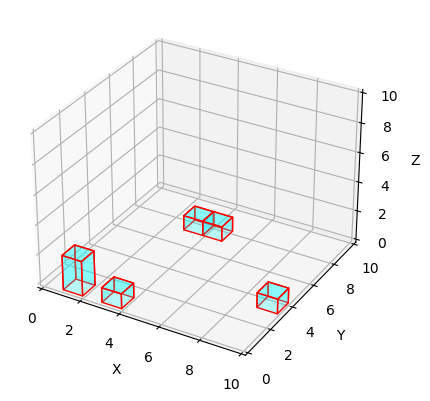

In [164]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from mpl_toolkits.mplot3d import Axes3D
import numpy as np



# Create a Matplotlib 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create vertices for the building
for i in range(len(env.boxes)):
    x = env.boxes[i][0]
    y = env.boxes[i][1]
    length = env.boxes[i][2]
    width = env.boxes[i][3]
    height = env.boxes[i][4]

    vertices = np.array([
        [x, y, 0],
        [x, y + width, 0],
        [x + length, y + width, 0],
        [x + length, y, 0],
        [x, y, height],
        [x, y + width, height],
        [x + length, y + width, height],
        [x + length, y, height]
    ])

    # Define faces of the building
    faces = [
        [vertices[0], vertices[1], vertices[5], vertices[4]],
        [vertices[7], vertices[6], vertices[2], vertices[3]],
        [vertices[0], vertices[4], vertices[7], vertices[3]],
        [vertices[1], vertices[5], vertices[6], vertices[2]],
        [vertices[4], vertices[5], vertices[6], vertices[7]]
    ]

    # Plot the building
    ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Set plot limits
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_zlim([0, 10])

# Display the plot
plt.show()
